## Notes

Modules can be used as stand-alones in simple applications and they can be combined for more complex use cases.


### Elements of the app
- **LLM:** The language model is the core reasoning engine here. In order to work with LangChain, you need to understand the different types of language models and how to work with them.
- **Prompt Templates:** This provides instructions to the language model. This controls what the language model outputs, so understanding how to construct prompts and different prompting strategies is crucial.
- **Output Parsers:** These translate the raw response from the LLM to a more workable format, making it easy to use the output downstream.

# Imports

In [43]:
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI

from langchain.schema import HumanMessage

from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate

from langchain.schema import BaseOutputParser

# inputs

In [ ]:
input_product = "colorful socks"

input_text_1 = "hi!, what is the capital of Poland"
input_text_2 = f"What would be a good company name for a company that makes {input_product}?"
input_text = input_text_2

# LLM

In [39]:
# model name
# local model: GPT4All or LLaMA2
model_name = 'text-davinci-003'

# temperature
temperature = 0.7

# LLMs: this is a language model which takes a string as input and returns a string
llm = OpenAI(model_name=model_name, temperature=temperature)

# predict Takes in a string, returns a string
chat_model = ChatOpenAI(temperature=temperature)

In [40]:
llm.predict(input_text)

'\n\nBoldSox.'

In [41]:
chat_model.predict(input_text)

'VibrantVibe Socks'

In [27]:
# predict_messages / multiple lines and add temperature (tmp from the model can be overriden here)
messages = [HumanMessage(content=input_text, temperature=0.7)]

In [28]:
llm.predict_messages(messages)

AIMessage(content='\n\nSocktopus.', additional_kwargs={}, example=False)

In [29]:
chat_model.predict_messages(messages)

AIMessage(content='Vibrant Feet', additional_kwargs={}, example=False)

# Prompt templates
adds the user input to a larger piece of text, called a prompt template, that provides additional context on the specific task at hand

In [31]:
# predefined context
template = "What is a good name for a company that makes {product}?"
prompt = PromptTemplate.from_template(template)
# produc that is being passed by the user
prompt.format(product=input_product)

'What is a good name for a company that makes colorful socks?'

In [34]:
chat_template = "You are a helpful assistant that translates {input_language} to {output_language}."
human_template = "{text}"

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", chat_template),
    ("human", human_template),
])

chat_prompt.format_messages(input_language="English", output_language="French", text="I love programming.")

[SystemMessage(content='You are a helpful assistant that translates English to French.', additional_kwargs={}),
 HumanMessage(content='I love programming.', additional_kwargs={}, example=False)]

# Output parsers
OutputParsers convert the raw output of an LLM into a format that can be used downstream

In [44]:
class CommaSeparatedListOutputParser(BaseOutputParser):
    """Parse the output of an LLM call to a comma-separated list."""


    def parse(self, text: str):
        """Parse the output of an LLM call."""
        return text.strip().split(", ")

CommaSeparatedListOutputParser().parse("hi, bye")

['hi', 'bye']

# Simplified flow from UI to LLM (asking questions)

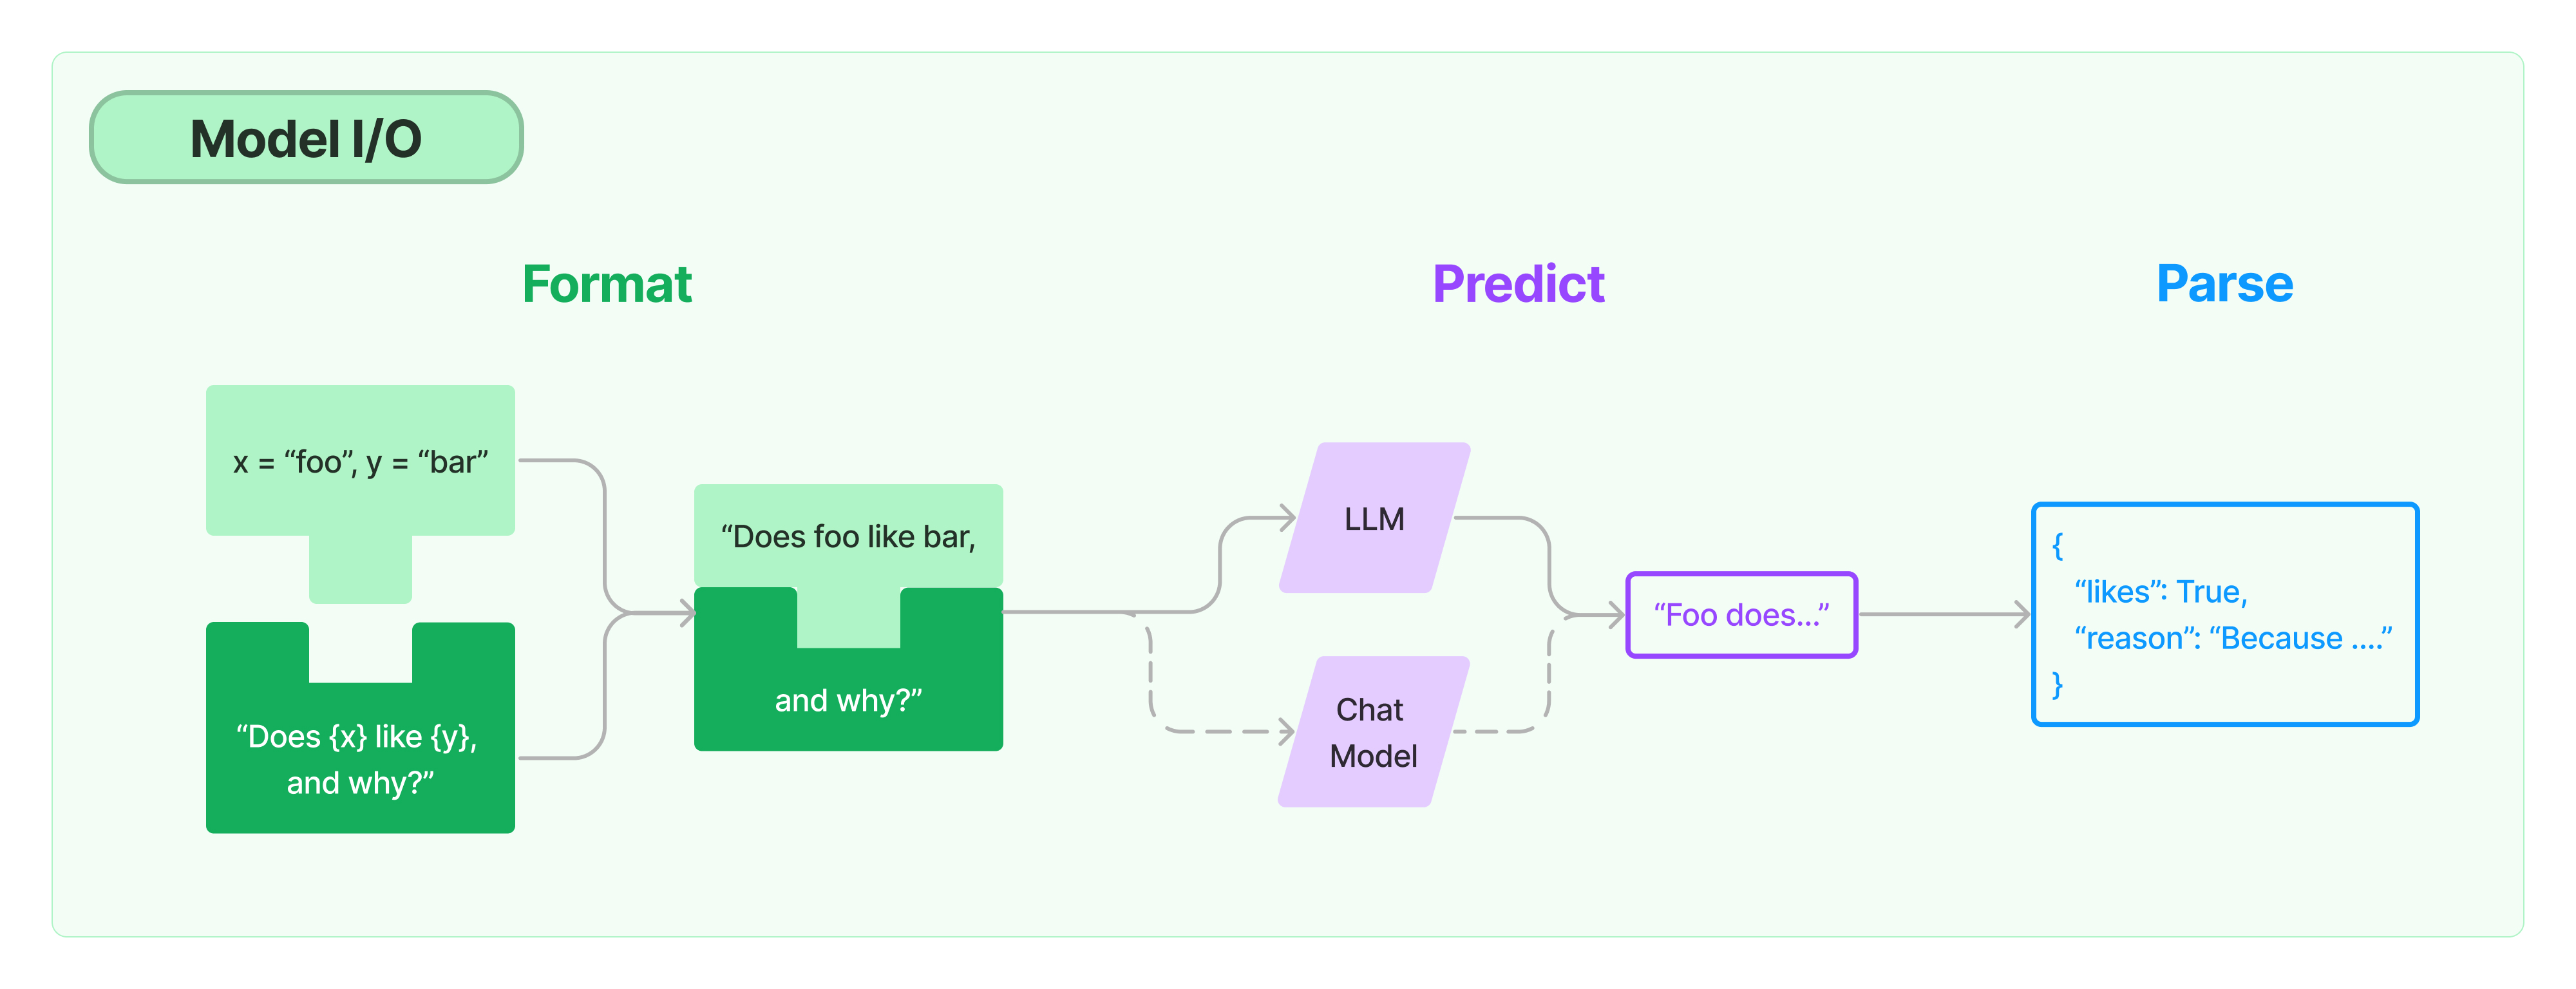

# Simplified flow for uplaoding documents

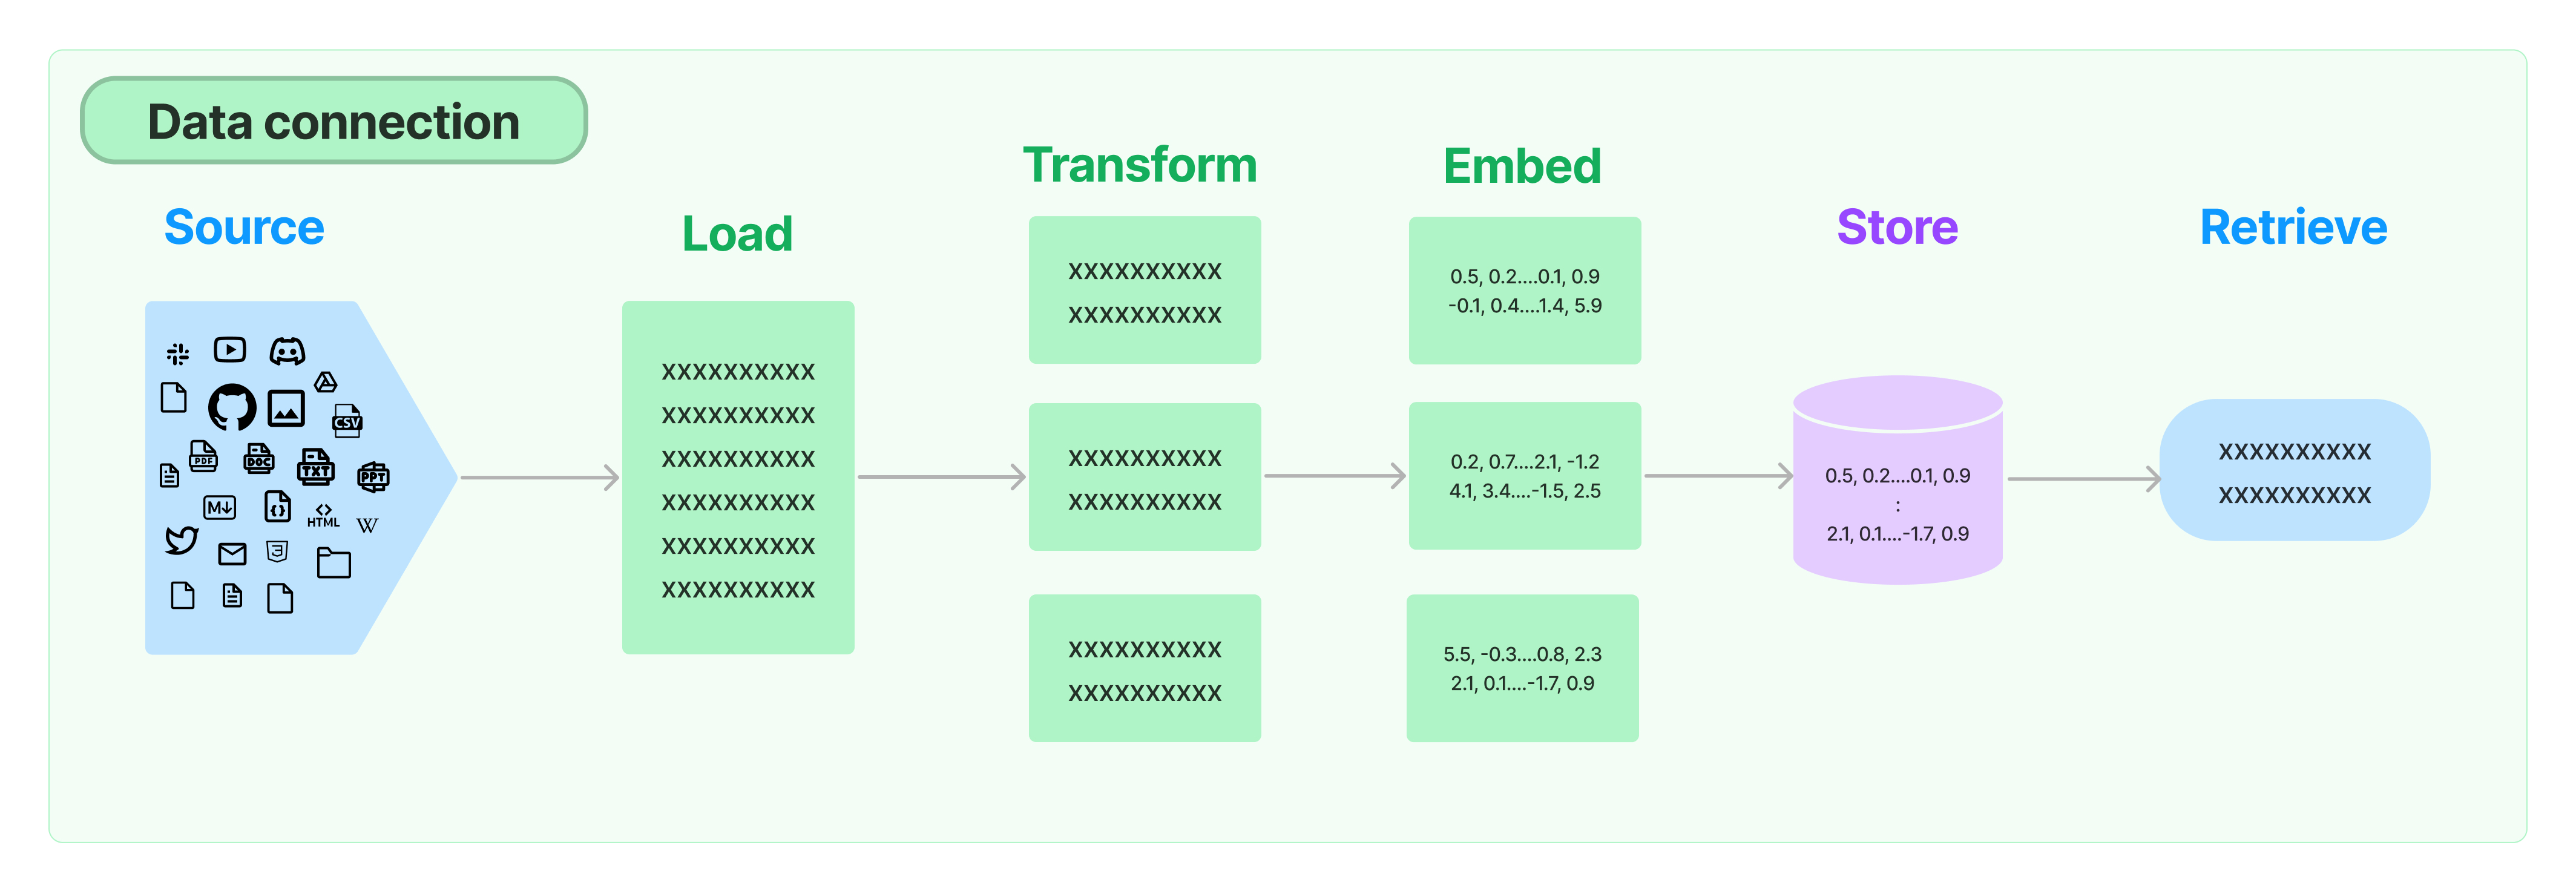

- doc load e.g: https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf
- fetching only the relevant parts of documents (splitting / chunking a large document into smaller chunks.)
- Text embedding models ( Embeddings capture the semantic meaning of the text, allowing you to quickly and efficiently find other pieces of text that are similar)
- Vector stores (databases supporting efficient storage and searching of these embeddings) e.g.: https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.chroma.Chroma.html
- Retrievers (supports retrieve documents from multiple different sources)

# Use case will bring Chains, Agents and Callbacks
### Agent
The core idea of agents is to use an LLM to choose a sequence of actions to take. In chains, a sequence of actions is hardcoded (in code). In agents, a language model is used as a reasoning engine to determine which actions to take and in which order.
### Chain
Using an LLM in isolation is fine for simple applications, but more complex applications require chaining LLMs - either with each other or with other components.
### callbacks 
callbacks system that allows you to hook into the various stages of your LLM application. 
- on_llm_start()
- on_llm_end()
...

# Upload pdf
https://python.langchain.com/docs/use_cases/question_answering/
https://python.langchain.com/docs/use_cases/question_answering/how_to/local_retrieval_qa
https://python.langchain.com/docs/modules/data_connection/document_loaders/pdf

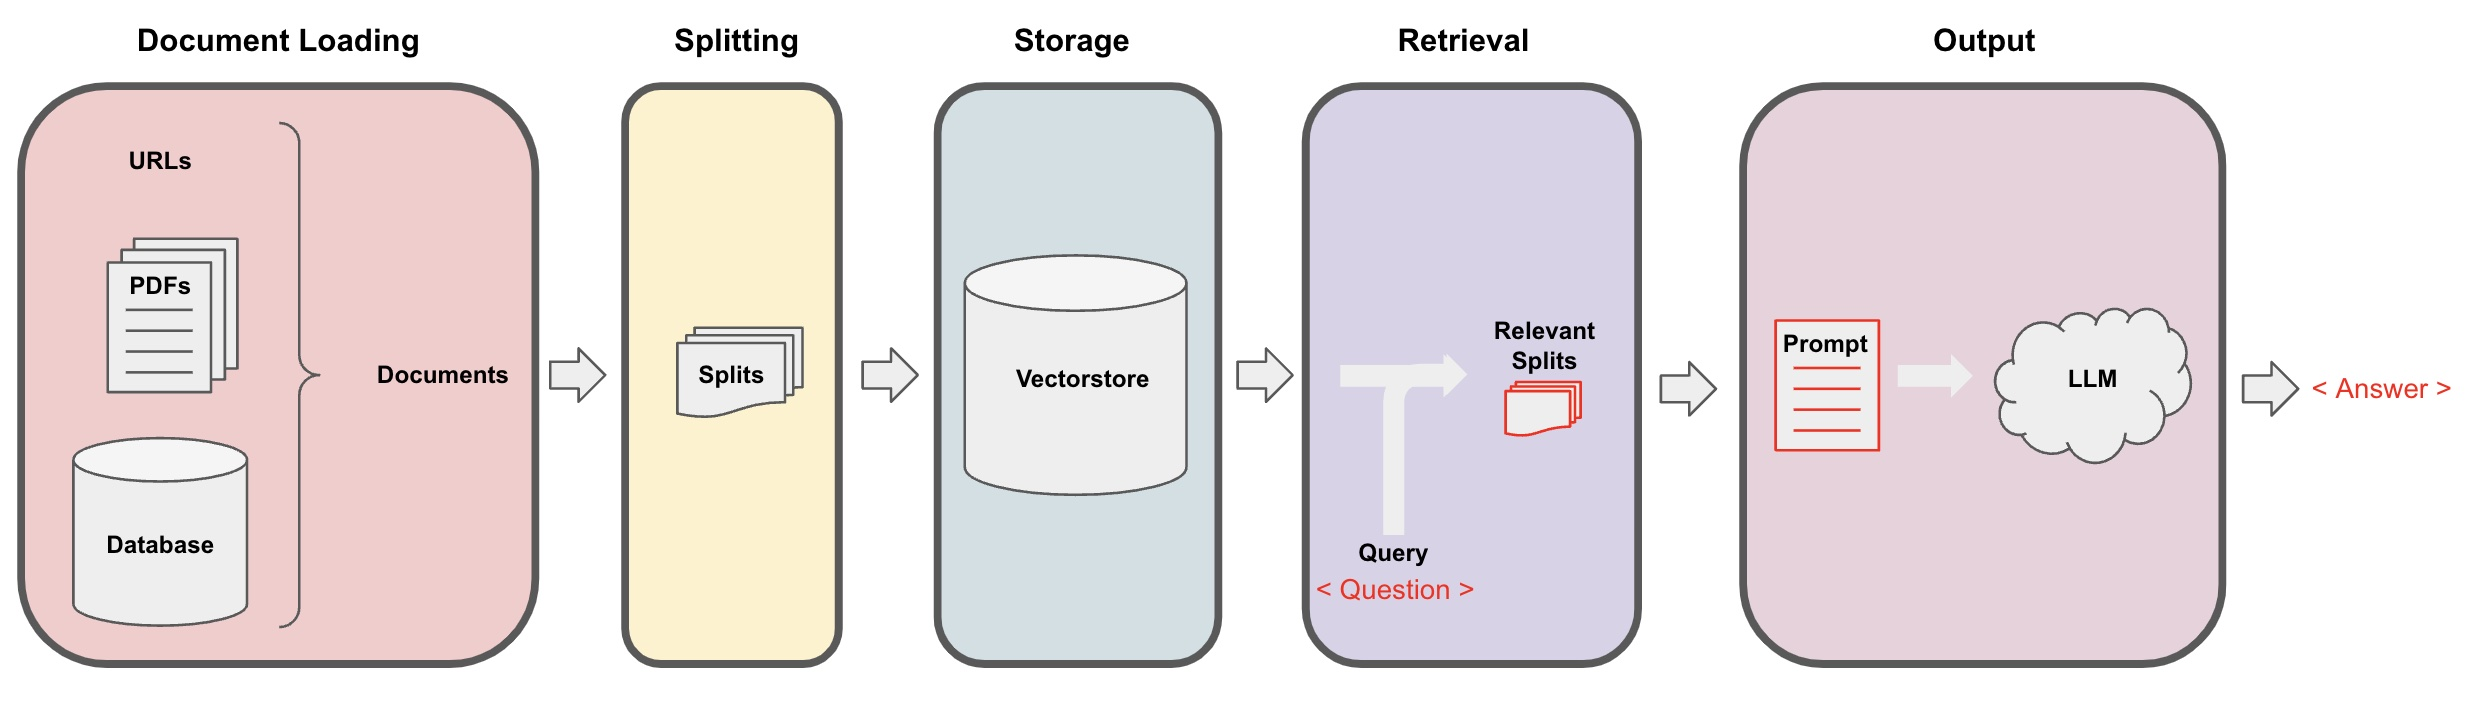

In [68]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain.text_splitter import RecursiveCharacterTextSplitter

# from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings import GPT4AllEmbeddings
from langchain.vectorstores import Chroma

### LOAD and SPLIT

In [95]:
loader = PyPDFLoader("bcbs238.pdf")
# we use text splitter in order to avoid: # Bert ERROR: The prompt is 2358 tokens and the context window is 512! 
# during  RetrievalQA.from_chain_type in next steps
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
# list of Document() objects
pages = loader.load_and_split(text_splitter)
# load_and_split(text_splitter: Optional[TextSplitter] = None)


# # if the text would be cp past then split would need be needed:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
# # list of Document() objects
# pages = text_splitter.split_documents(on_big_text)

### STORE

In [96]:
vectorstore = Chroma.from_documents(documents=pages, embedding=GPT4AllEmbeddings())

Found model file at  /Users/mz/.cache/gpt4all/ggml-all-MiniLM-L6-v2-f16.bin


### RETRIVE

In [103]:
question = "What is liquidity"
docs = vectorstore.similarity_search(question)
len(docs)

4

In [104]:
docs[0]

Document(page_content='128.  A liquidity facility is defined as any committed, undrawn back -up facility that would \nbe utilised to refinance the debt obligations  of a customer in situations where such a \ncustomer is unable to rollover that debt in financial markets (eg pursuant to a commercial \npaper programme, secured financing transactions, obligations to redeem units, etc). For the', metadata={'page': 36, 'source': 'bcbs238.pdf'})

### GENERATE

In [111]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.llms import GPT4All

# select different model https://integrations.langchain.com/
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

## after runing pip install gpt4all; the mode is stored in: /Users/<user_name>/.cache/gpt4all
# model_path = "/Users/mz/.cache/gpt4all/ggml-all-MiniLM-L6-v2-f16.bin"
# llm = GPT4All(
#     model=model_path,
#     max_tokens=2048,
# )
# https://python.langchain.com/docs/integrations/llms/llamacpp
# https://agi-sphere.com/install-llama-mac/#Step_5_Install_Python_dependence
# llm = OpenAI(model_name=model_name, temperature=temperature)

qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectorstore.as_retriever())
qa_chain({"query": question})

{'query': 'What is liquidity',
 'result': 'Liquidity refers to the ease with which an asset or security can be bought or sold in the market without causing significant price changes. It is a measure of how quickly an asset can be converted into cash without impacting its market value. High liquidity means that there is a large volume of buyers and sellers in the market, making it easy to buy or sell the asset. Low liquidity means that there are fewer buyers and sellers, making it more difficult to buy or sell the asset without affecting its price.'}